In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from UnifiedMomentumModel.Momentum import UnifiedMomentum

# Analytical Models

## Define Analytical Models

In [102]:
def classical(ctp):  # return Cp for classical momentum theory
    a = ctp / (4 + ctp)
    return 4 * a * (1 - a)**2

In [103]:
def johlas(ctp, sa, pa):  # return Cp for classical momentum theory adjusted by coefficents in Johlas 2020
    cp = classical(ctp)
    x_disp = (1 + (3 * (sa**2)) / 2)
    theta_disp = np.mean([np.cos(np.deg2rad(pa) * np.sin(x))**3 for x in np.linspace(0, 2 * np.pi, 250)])
    return cp * x_disp * theta_disp  # coefficents from turbine movement

In [104]:
def umm(ctp, sf, sa, pa):
    model = UnifiedMomentum()
    sf_rad = np.deg2rad(sf)
    sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
    sa_vals = (sa * sin_vals) + 1
    sa_vals_cubed = sa_vals**3
    pa_vals = np.deg2rad(pa) * sin_vals
    umm_vals = np.array([np.mean(sa_vals_cubed * model(Ctprime = c, yaw = 0.0, tilt = pa_vals).Cp) for c in np.atleast_1d(ctp)])
    return umm_vals

## Plot Analytical Models

In [105]:
palette =['tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:red']

### For this initial exploration, we will use $f = 1.0$ and $A_S = 0.5$ & $A_P = 5^\circ$. 

In [106]:
ctp_list = np.linspace(0.01, 10, num = 100)

In [107]:
def fix_plot_legend(ax, xOffset = 1.85, title = ""):
    leg = ax.legend(title = title)
    bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
    return

In [108]:
def plot_mean_cp_models(ctp_list, f, sa, pa, palette = palette):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (10, 4), dpi = 300)
    fig.suptitle("Mean $C_P$ vs $C_T^'$", size = 16, y = 1.04)
    ax0.set_title(f"Surging ($f = {f}$, A = ${sa}$)", size = 14, y = 1.04)
    ax1.set_title(f"Pitching ($f = {f}$, A = ${pa}^\circ$)", size = 14, y = 1.04)
    ax0.set_xlabel('$C_T^\'$', size = 15)
    ax1.set_xlabel('$C_T^\'$', size = 15)
    ax0.set_ylabel('Mean $C_P$', size = 15)
    ax1.set_ylabel('Mean $C_P$', size = 15)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax0.set_ylim(0, 1)
    linewidth = 3.5
    classical_cp = classical(ctp_list)
    # plot surging
    johlas_cp_surge = johlas(ctp_list, sa, 0)
    umm_cp_surge = umm(ctp_list, f, sa, 0)
    sns.lineplot(ax = ax0, x = ctp_list, y = classical_cp, color=palette[0], label = "Classical", linewidth = linewidth)
    sns.lineplot(ax = ax0, x = ctp_list, y = johlas_cp_surge, color=palette[1], label = "Johlas", linewidth = linewidth)
    sns.lineplot(ax = ax0, x = ctp_list, y = umm_cp_surge, color=palette[2], label = "Quasi-Steady UMM", linewidth = linewidth)
    # plot pitching
    johlas_cp_pitch = johlas(ctp_list, 0, pa)
    umm_cp_pitch = umm(ctp_list, f, 0, pa)
    sns.lineplot(ax = ax1, x = ctp_list, y = classical_cp, color=palette[0], linewidth = linewidth, legend=False)
    sns.lineplot(ax = ax1, x = ctp_list, y = johlas_cp_pitch, color=palette[1], linewidth = linewidth, legend=False)
    sns.lineplot(ax = ax1, x = ctp_list, y = umm_cp_pitch, color=palette[2], linewidth = linewidth, legend=False)

    # adjust plot legend and spacing
    fix_plot_legend(ax0)
    fig.subplots_adjust(wspace=0.25)
    return fig, (ax0, ax1)


/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:89: RuntimeWarning: invalid value encountered in divide
  cos_a = np.divide(np.sin(yaw), sin_eff, where = tilt != 0, out = cos_a)
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:90: RuntimeWarning: divide by zero encountered in divide
  sin_a = np.divide(-(np.sin(tilt) * np.cos(yaw)), sin_eff, where = tilt != 0, out = sin_a)
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:94: RuntimeWarning: invalid value encountered in multiply
  w = sin_a * eff_v


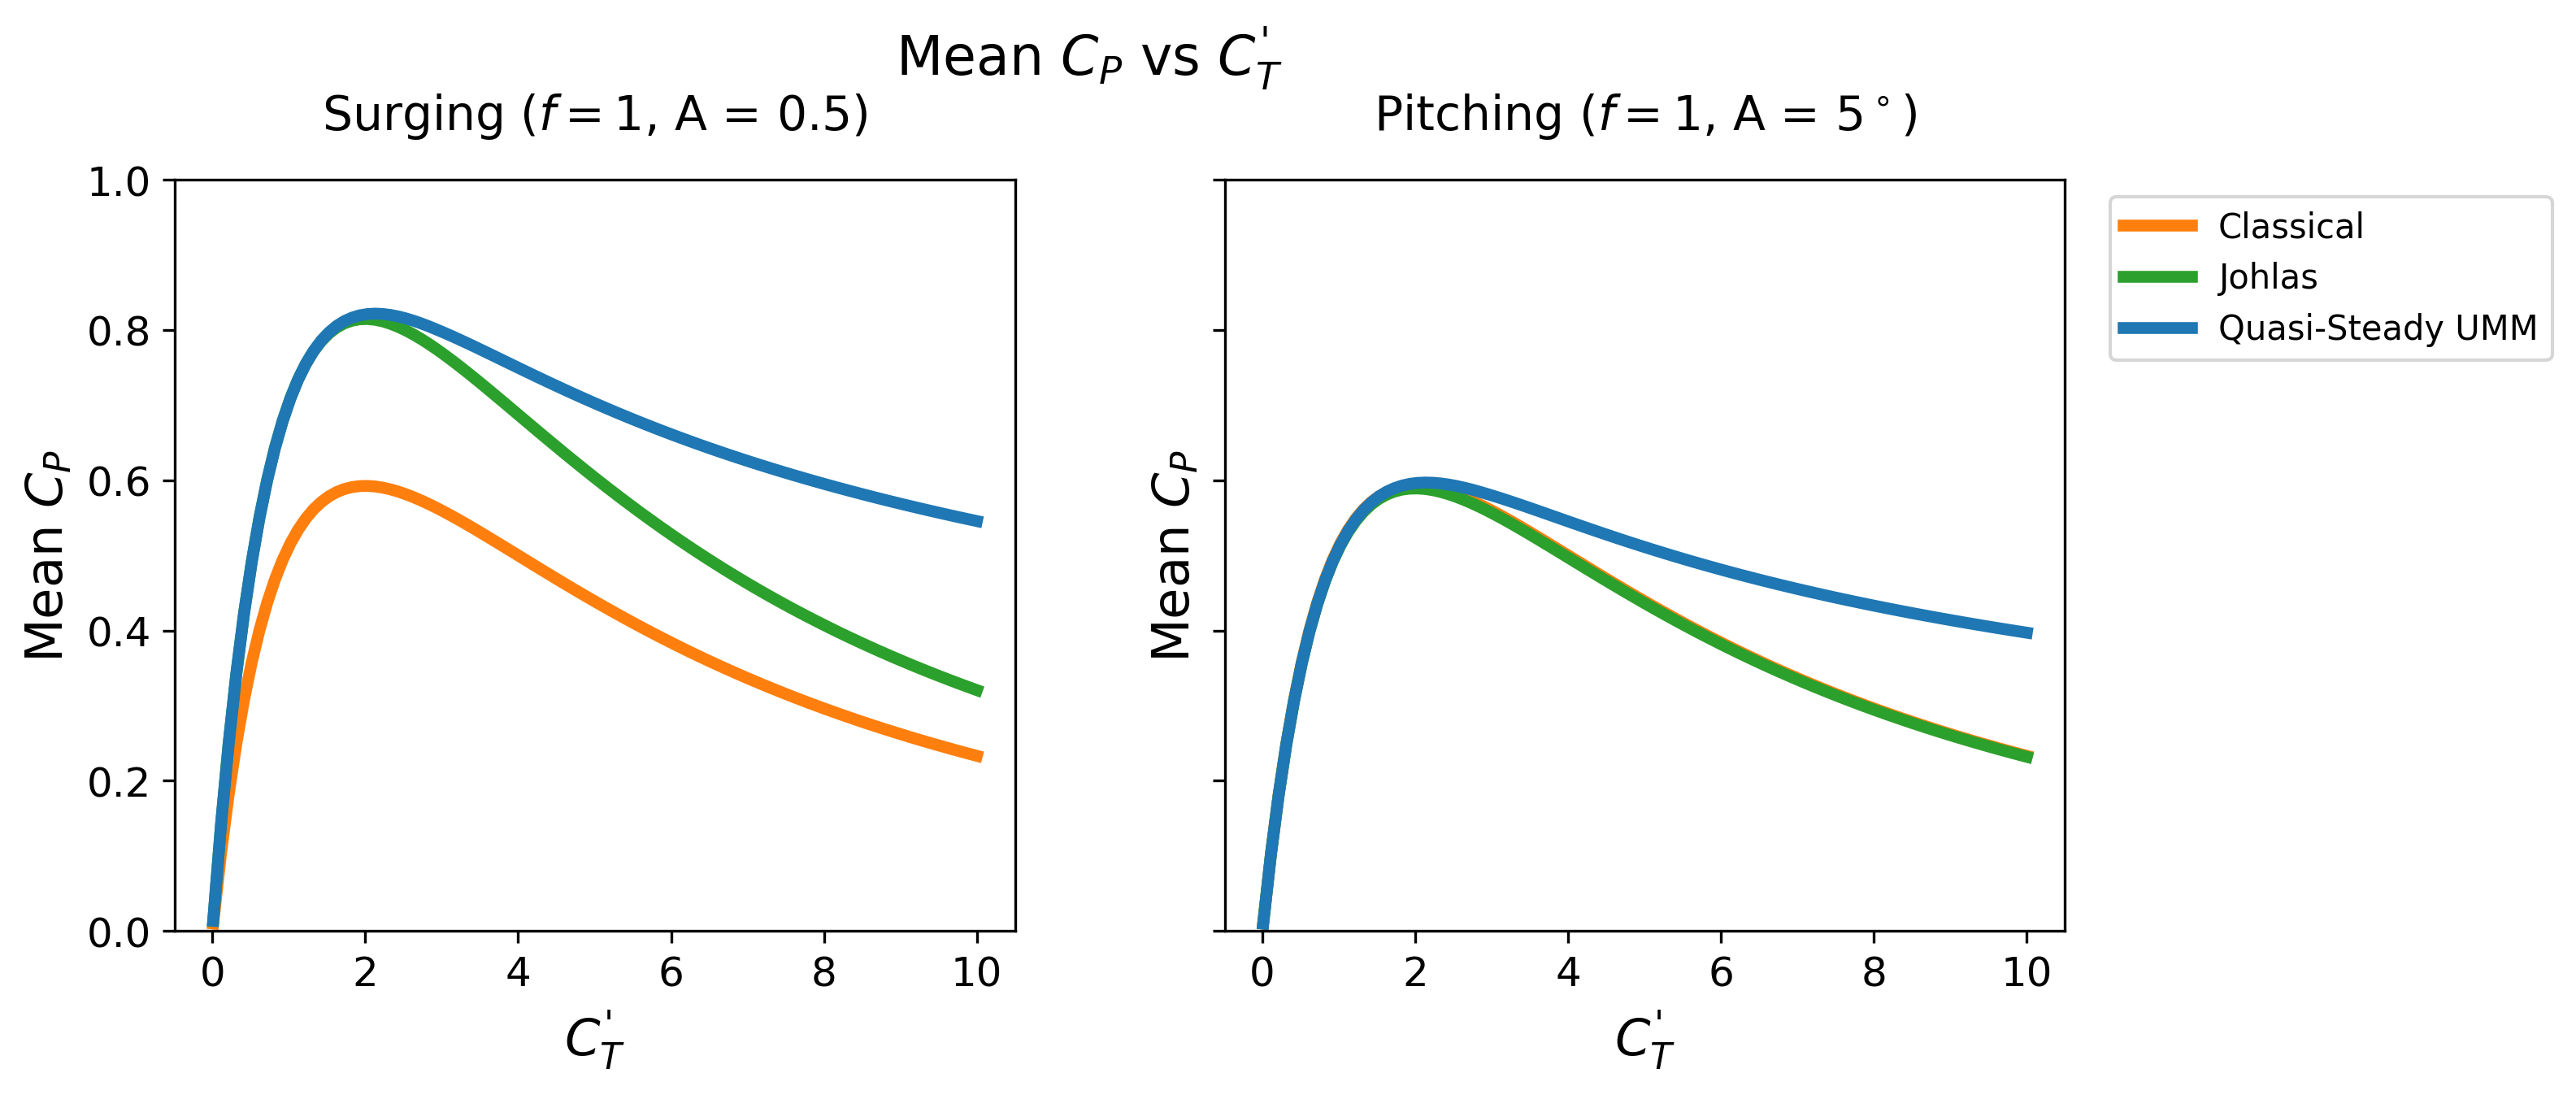

In [109]:
f, sa, pa = 1, 0.5, 5
plot_mean_cp_models(ctp_list, f, sa, pa);

# Analyze LES Data

In [110]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

df = pd.read_csv("/Users/sky/src/HowlandLab/data/expanded_moving_analysis_july_27_25.csv")
df['Movement'] = df.apply(lambda row: ("Stationary" if row.marker == "o" else ("Surging" if row.marker == "s" else "Pitching")), axis = 1)
df['rounded_dt'] = df.apply(lambda row: round(row["dt"], ndigits = 3), axis = 1)
df = df[df.nx >= 256]  # only keep simulations with high enough resolutions
df = df[df.filterFactor >= 1.5] # only keep simulations with high enough filter factors
df = df[df.useCorrection]
df = df[df.turbulence == False]

## Sensitivity to LES Parameters

## Failed Runs

Some runs fail due to instability. The runs are more likely to fail when the resolution is increased, as the floe fields are less smooth. In order to resolve these fields, the timestep may need to be decreased. When attempting to increase the resolution, I had quite a few runs fail at $C_T' = 4$. In hindsight, running at this high of a $C_T'$ might not even be physical, so I decided to move on and work with more reasonable $C_T'$ values. However, here I cataloged the runs that became unstable and crashed.

In [111]:
df_nans = df[df.isna().any(axis=1)]
df_nans = df_nans.sort_values(by = ["nx", "dt", "filterFactor", "surge_freq", "surge_amplitude", "pitch_amplitude"])
df_nans[["CT_prime", "nx", "ny", "dt", "filterFactor", "filter", "surge_freq", "surge_amplitude", "pitch_amplitude", "mean_Cp"]]

,CT_prime,nx,ny,dt,filterFactor,filter,surge_freq,surge_amplitude,pitch_amplitude,mean_Cp
211,4.0,256.0,128.0,0.041667,1.5,0.221187,1.5,1.0,0.0,NaN
212,4.0,256.0,128.0,0.041667,2.5,0.368644,1.5,1.0,0.0,NaN
169,4.0,256.0,128.0,0.062500,1.5,0.221187,0.1,1.0,0.0,NaN
170,4.0,256.0,128.0,0.062500,1.5,0.221187,0.5,1.0,0.0,NaN
171,4.0,256.0,128.0,0.062500,1.5,0.221187,1.0,1.0,0.0,NaN
209,4.0,256.0,128.0,0.062500,1.5,0.221187,1.0,1.0,0.0,NaN
210,4.0,256.0,128.0,0.062500,2.5,0.368644,1.0,1.0,0.0,NaN
221,4.0,256.0,128.0,0.062500,3.5,0.516102,1.0,1.0,0.0,NaN
239,4.0,512.0,256.0,0.024414,1.5,0.110593,0.1,0.5,0.0,NaN
242,4.0,512.0,256.0,0.048828,1.5,0.110593,0.0,0.0,0.0,NaN


We can see here that the runs with $nx = 256$ that crashed all has a surge amplitude of $1$. This makes sense, as this basically brings the turbine to a standstill. Then, for $nx = 512$, the runs will smaller surge frequencies and amplitude of 0.5 all crashed. To fix this, I tried all different filter factors (1.5 - 3.5), but this didn't help. Lowering the timestep artifically low for the higher frequency runs did help. This makes sense as this helps to resolve the more complex flow field. 

### Plot the Unstable Surging Runs (all but one!)

<Axes: title={'center': '$n_x = 512$'}, xlabel='Frequency [St]', ylabel=' '>

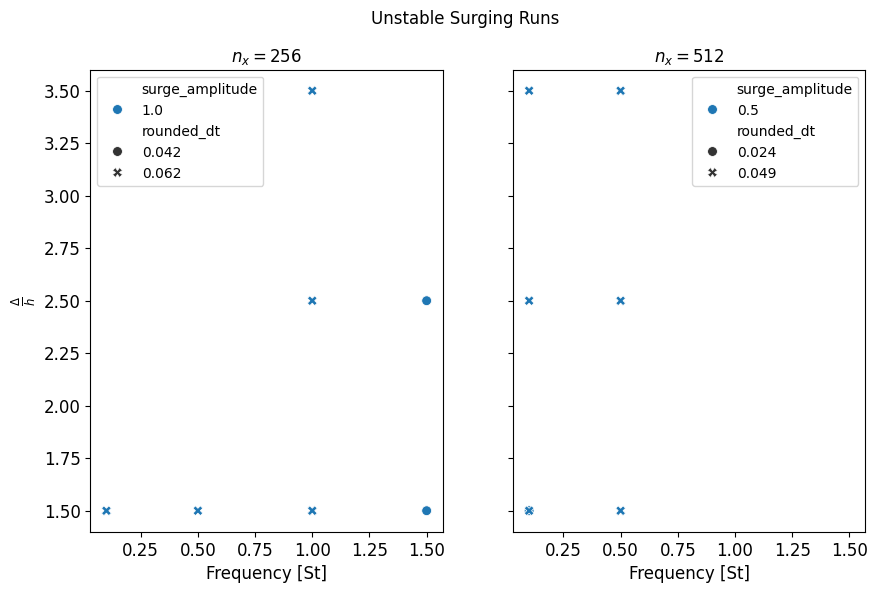

In [112]:
fig, (ax0, ax1) = plt.subplots(1, 2, dpi = 100, figsize = (10, 6), sharey = True, sharex = True)
fig.suptitle("Unstable Surging Runs")
ax0.set_title("$n_x = 256$")
ax0.set_xlabel('Frequency [St]', size = 12)
ax0.set_ylabel('$\\frac{\Delta}{h}$', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.set_title("$n_x = 512$")
ax1.set_xlabel('Frequency [St]', size = 12)
ax1.set_ylabel(' ', size = 12)
ax1.tick_params(axis='both', which='major', labelsize=12)

sns.scatterplot(ax = ax0, data = df_nans[(df_nans.surge_amplitude != 0) & (df_nans.nx == 256)], x = "surge_freq", y = "filterFactor", hue = "surge_amplitude", style = "rounded_dt", palette = "tab10", s = 50)
sns.scatterplot(ax = ax1, data = df_nans[(df_nans.surge_amplitude != 0) & (df_nans.nx == 512)], x = "surge_freq", y = "filterFactor", hue = "surge_amplitude", style = "rounded_dt", palette = "tab10", s = 50)

## Completed Runs

We now consider all of the rest of the runs that sucessfully completed.

In [113]:
df = df.dropna()
cols_to_keep = ["Movement", "nx", "filterFactor", "filterFactor", "useCorrection", "turbulence", "CT_prime", "surge_freq", "surge_amplitude", "pitch_amplitude"]
df = df.drop_duplicates(subset = cols_to_keep, keep = 'last')

We also create a few specialized datasets to help us plot specific subsets of the data, either by frequency and amplitude, or by LES parameters.

In [114]:
low_res_df = df[(df.ny == 128) & (df.filterFactor == 1.5)]
high_res_df = df[(df.ny == 256)]

## Plot Mean $C_P$ LES Data for $f = 1$, $A_s = 0.5$, and $A_p = 5^\circ$ over $C_T'$ Values

In [115]:
max_motion_df = low_res_df[low_res_df["surge_freq"] == 1]
max_motion_df = max_motion_df[(max_motion_df["surge_amplitude"] == 0.5) | (max_motion_df["pitch_amplitude"] == 5)]

/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:89: RuntimeWarning: invalid value encountered in divide
  cos_a = np.divide(np.sin(yaw), sin_eff, where = tilt != 0, out = cos_a)
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:90: RuntimeWarning: divide by zero encountered in divide
  sin_a = np.divide(-(np.sin(tilt) * np.cos(yaw)), sin_eff, where = tilt != 0, out = sin_a)
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:94: RuntimeWarning: invalid value encountered in multiply
  w = sin_a * eff_v


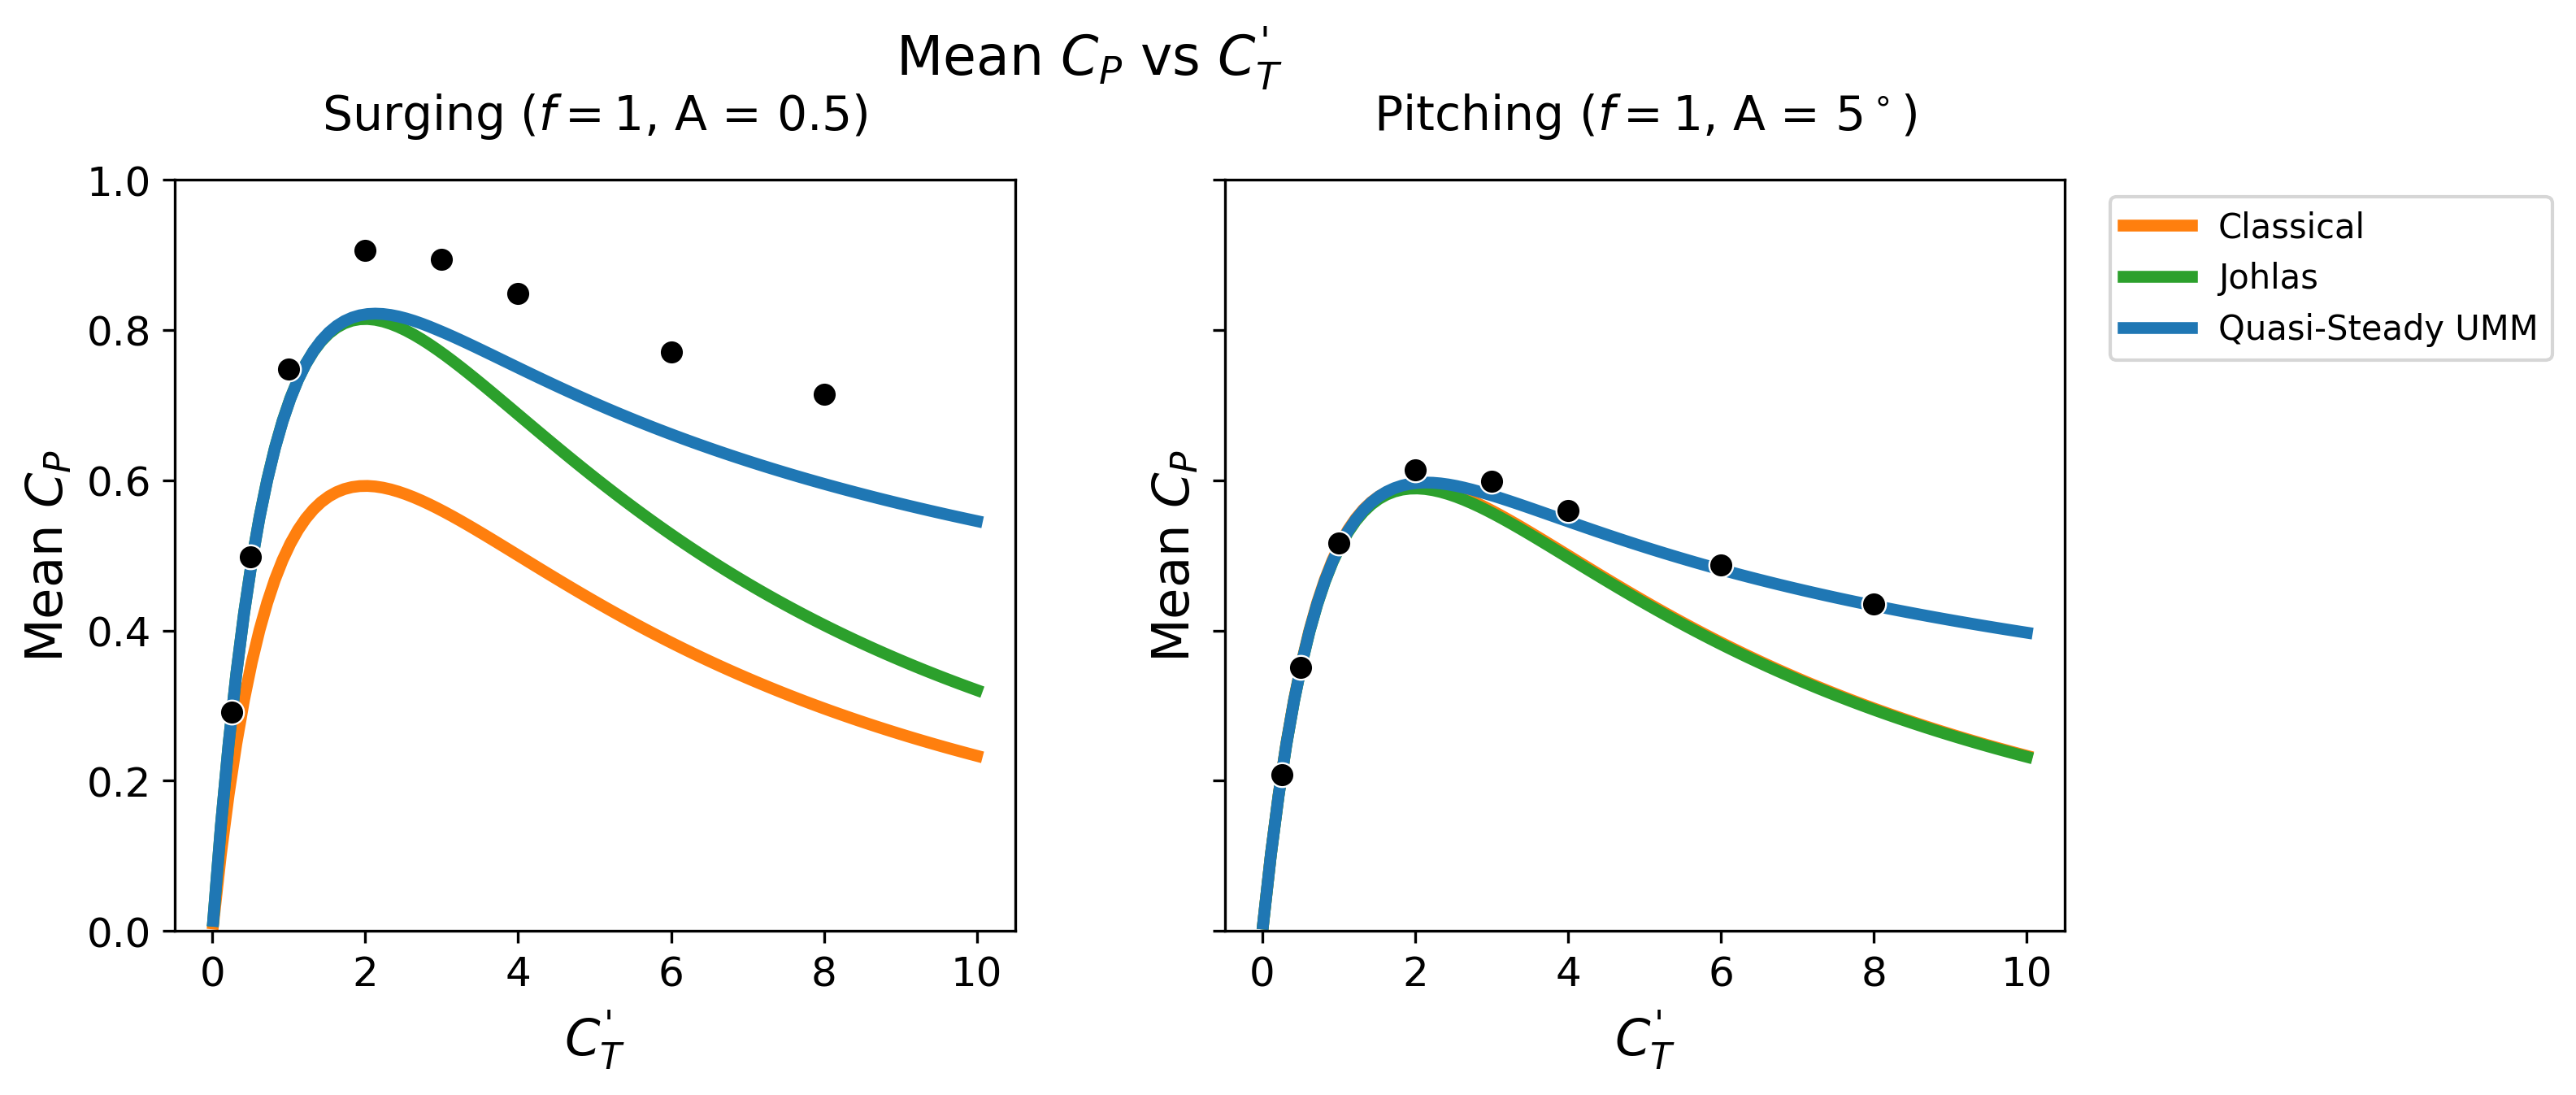

In [116]:
fig, (ax0, ax1) = plot_mean_cp_models(ctp_list, f, sa, pa);
surging_max_motion_df = max_motion_df[max_motion_df["Movement"] == "Surging"]
sns.scatterplot(ax  = ax0, data = surging_max_motion_df, x = "CT_prime", y = "mean_Cp", color = 'k', zorder = 5, s=50)
pitching_max_motion_df = max_motion_df[max_motion_df["Movement"] == "Pitching"]
sns.scatterplot(ax = ax1, data = pitching_max_motion_df, x = "CT_prime", y = "mean_Cp", color = 'k', zorder = 5, s=50, legend = False)
fix_plot_legend(ax0)

## Calculate Differences Between UMM and LES

In [117]:
df["umm"] = df.apply((lambda row: umm(row.CT_prime, row.surge_freq, row.surge_amplitude, row.pitch_amplitude)[0]), axis = 1)
df["percent_diff_umm"] = df.apply((lambda row: 100 * (row.umm - row.mean_Cp) / row.mean_Cp), axis = 1)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/3318810174.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/3318810174.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/FixedPointIteration.py:56: RuntimeWarning: All-NaN slice encountered
  max_resid = [np.nanmax(np.abs(_r)) for _r in residuals]
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7

In [118]:
def plot_umm_les(df, ctp, mask = None):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (8, 3), dpi = 300)
    fig.suptitle(f"Mean $C_P$ vs Amplitude for Varying Frequencies for $C_T' = {ctp}$", size = 16, y = 1.04)
    ax0.set_title("Surging", size = 14)
    ax1.set_title("Pitching", size = 14)
    ax0.set_xlabel('Amplitude [-]', size = 12)
    ax1.set_xlabel('Amplitude [$^\circ$]', size = 12)
    ax0.set_ylabel('Mean $C_P$', size = 12)
    ax1.set_ylabel(' ', size = 12)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    ax0_data = df[(df["Movement"] == "Surging") & (df["CT_prime"] == ctp)]
    ax1_data = df[(df["Movement"] == "Pitching") & (df["CT_prime"] == ctp)]
    if mask is not None:
        ax0_data = ax0_data[mask]
        ax1_data = ax1_data[mask]
    sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
    sns.lineplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "umm", color = "k", label = "UMM")

    sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)
    sns.lineplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "umm", color = "k")

    fix_plot_legend(ax0, xOffset = 1.7, title = "Frequency")
    fig.subplots_adjust(hspace = 0.5)


In [119]:
def plot_umm_error(df, ctp, mask = None):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (8, 3), dpi = 300)
    fig.suptitle(f"UMM Error vs Amplitude for Varying Frequencies for $C_T' = {ctp}$", size = 16, y = 1.04)
    ax0.set_title("Surging", size = 14)
    ax1.set_title("Pitching", size = 14)
    ax0.set_xlabel('Amplitude [-]', size = 12)
    ax1.set_xlabel('Amplitude [$^\circ$]', size = 12)
    ax0.set_ylabel('UMM $C_P$ Error [%]', size = 12)
    ax1.set_ylabel(' ', size = 12)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    surge_mask = (df["Movement"] == "Surging") & (df["CT_prime"] == ctp)
    pitch_mask = (df["Movement"] == "Pitching") & (df["CT_prime"] == ctp)
    if mask is not None:
        surge_mask = surge_mask & mask
        pitch_mask = pitch_mask & mask
    ax0_data = df[surge_mask]
    ax1_data = df[pitch_mask]

    sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
    sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)

    fix_plot_legend(ax0, xOffset = 1.7, title = "Frequency")
    fig.subplots_adjust(hspace = 0.5)


## Plot Mean $C_P$ from UMM for $C_T' = 1$ for a range of $f$ and $A$

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax0_data = ax0_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1_data = ax1_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:18: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:21: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq

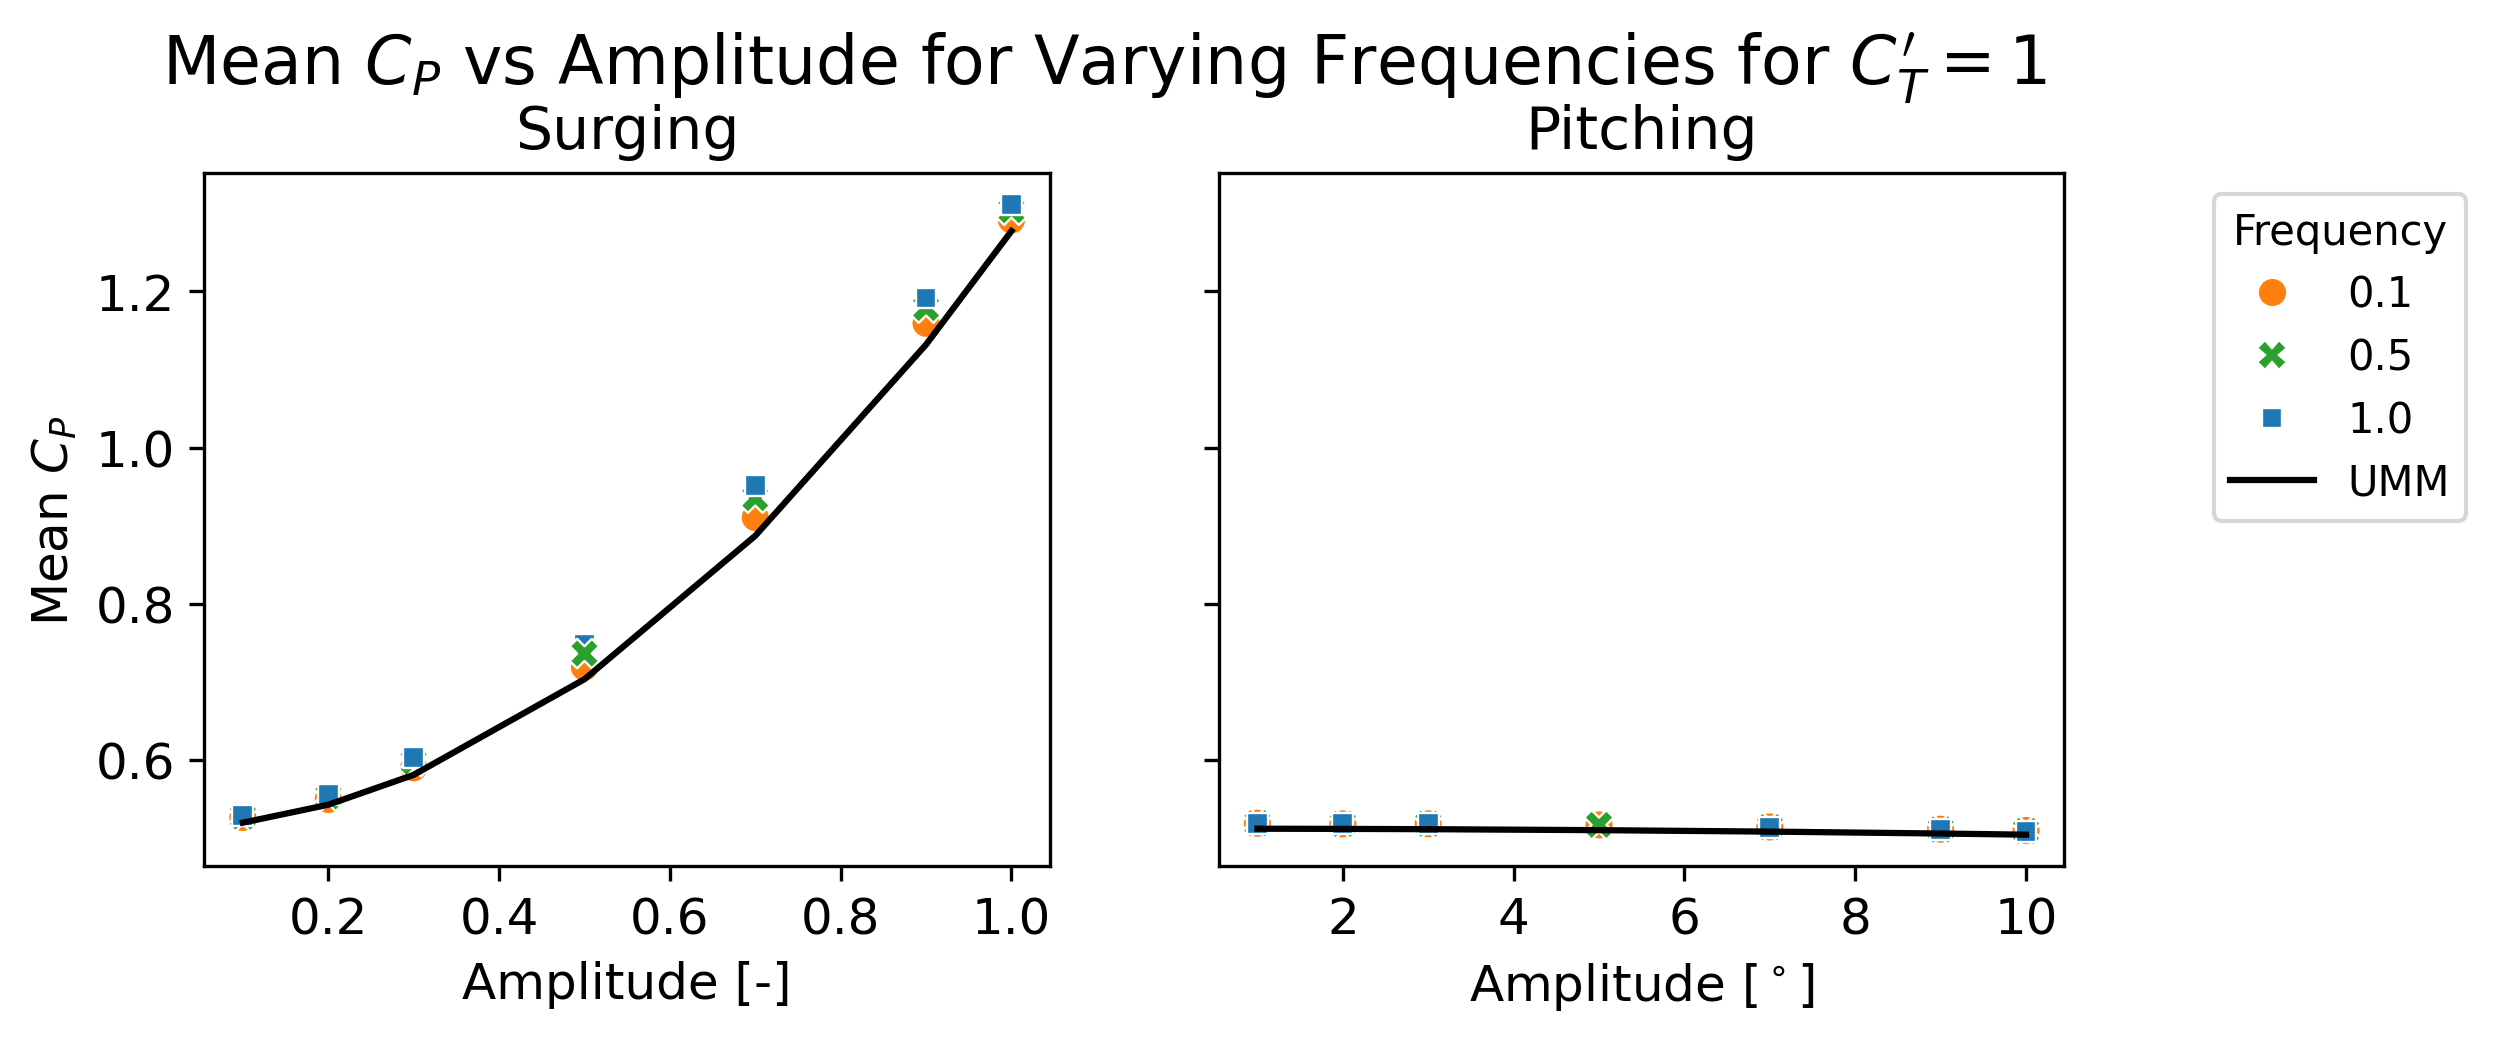

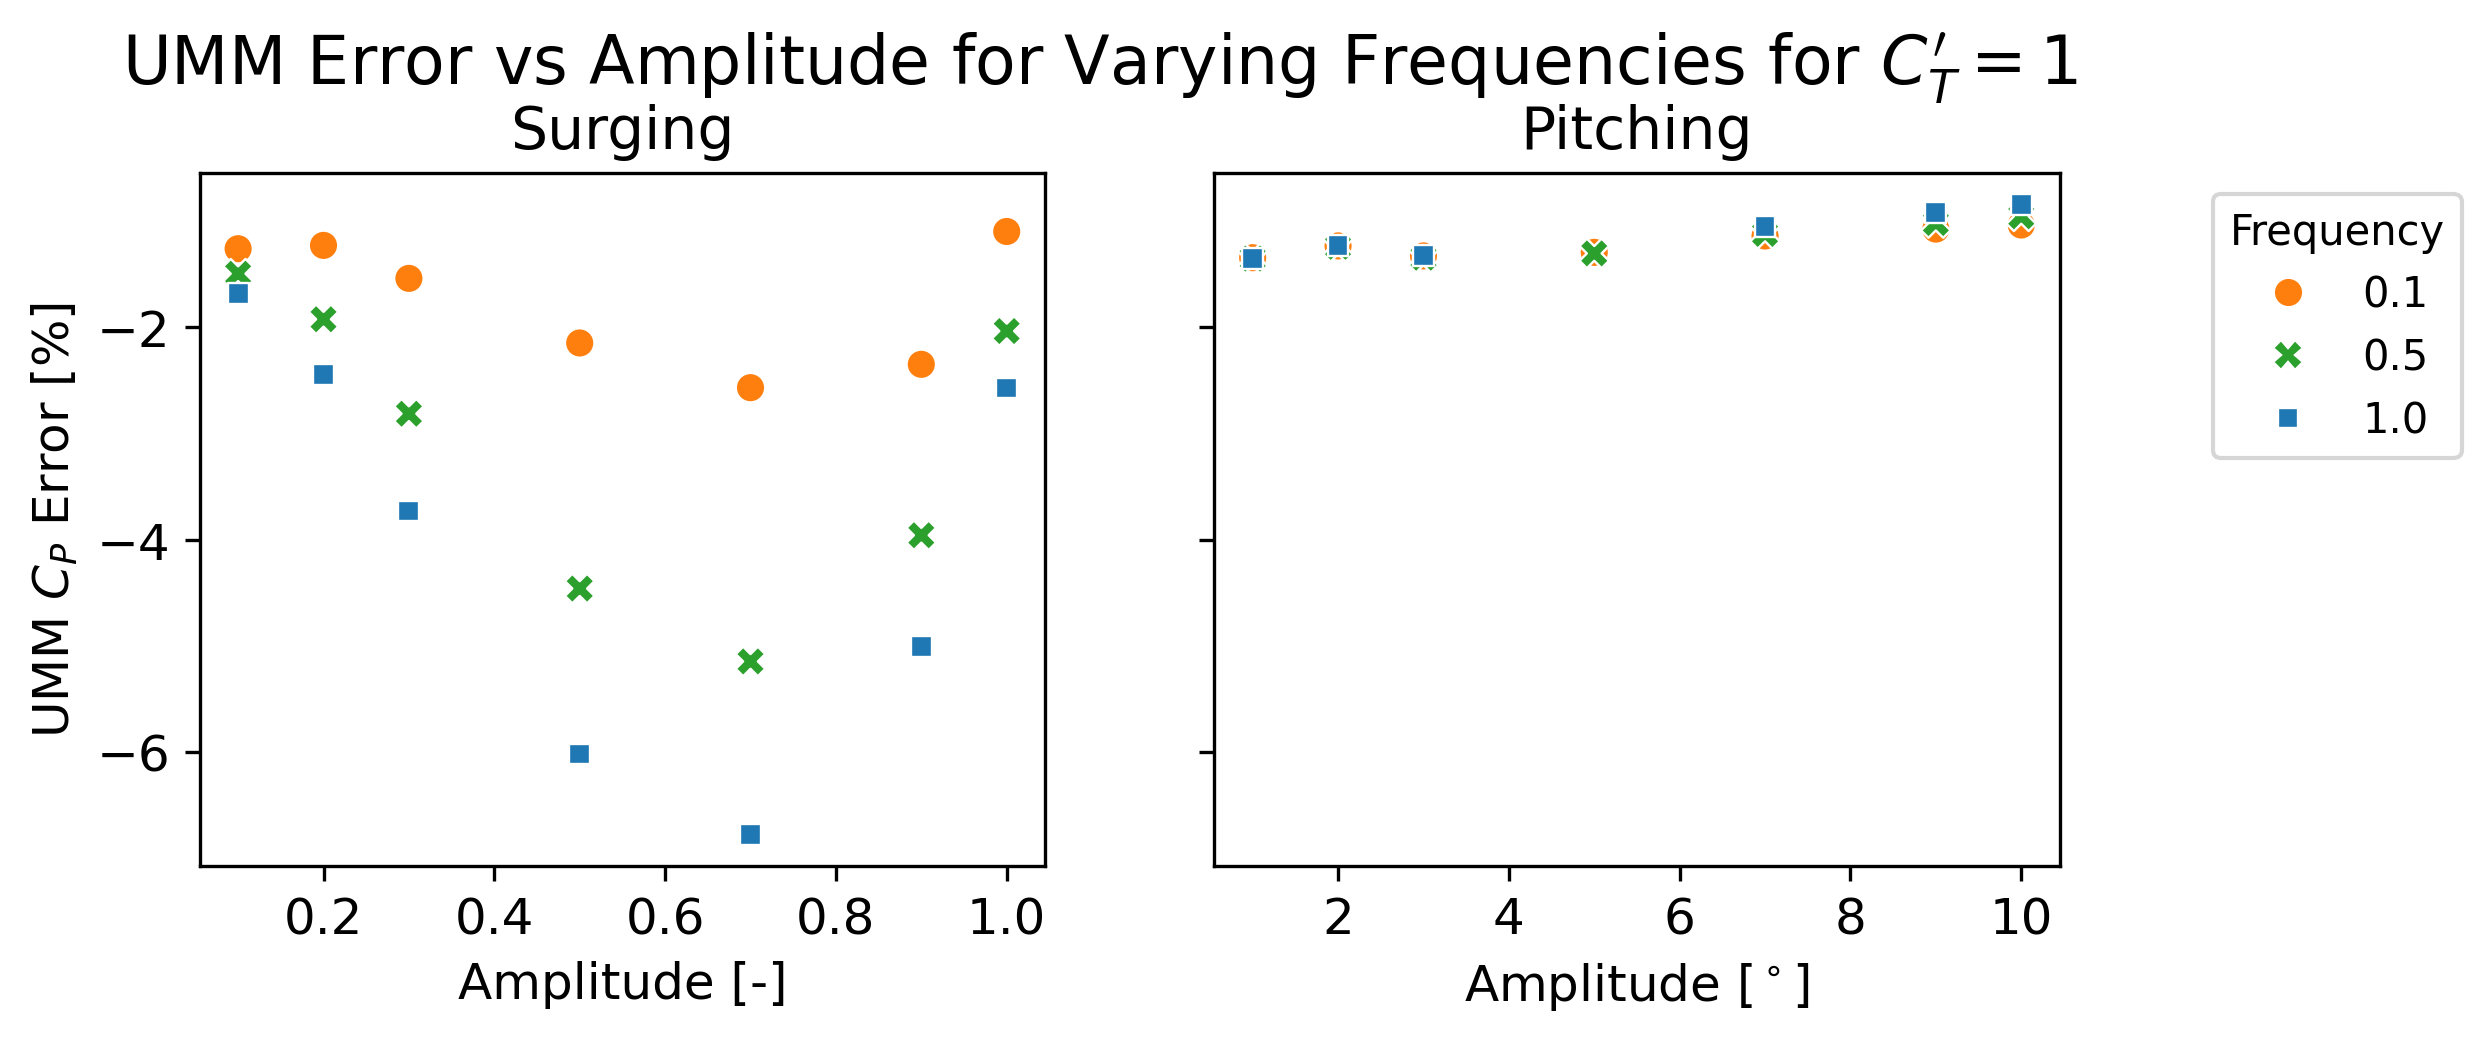

In [120]:
ctp = 1
mask = (df.filterFactor == 1.5) & (df.ny == 128) & (df.surge_freq < 1.5)
plot_umm_les(df, ctp, mask = mask)
plot_umm_error(df, ctp, mask = mask)

## Plot Mean $C_P$ from UMM for $C_T' = 2$ for a range of $f$ and $A$

In [121]:
df[df.CT_prime == 2]

,Unnamed: 0,marker,dt,nx,ny,filter,filterFactor,useCorrection,CT_prime,turbulence,...,skewness_CT,skewness_an,skewness_Cp,kurtosis_CT,kurtosis_an,kurtosis_Cp,Movement,rounded_dt,umm,percent_diff_umm
118,118,s,0.0625,256.0,128.0,0.221187,1.5,True,2.0,False,...,0.360949,0.010516,0.626217,-1.416732,-1.503832,-1.170981,Surging,0.062,0.821002,-9.376682
119,119,^,0.0625,256.0,128.0,0.221187,1.5,True,2.0,False,...,-0.016089,0.017929,-0.014250,-1.483688,-1.483533,-1.483837,Pitching,0.062,0.596299,-2.815336


/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax0_data = ax0_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1_data = ax1_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:18: UserWarning: The palette list has more values (5) than needed (1), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:21: UserWarning: The palette list has more values (5) than needed (1), which may not be intended.
  sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq

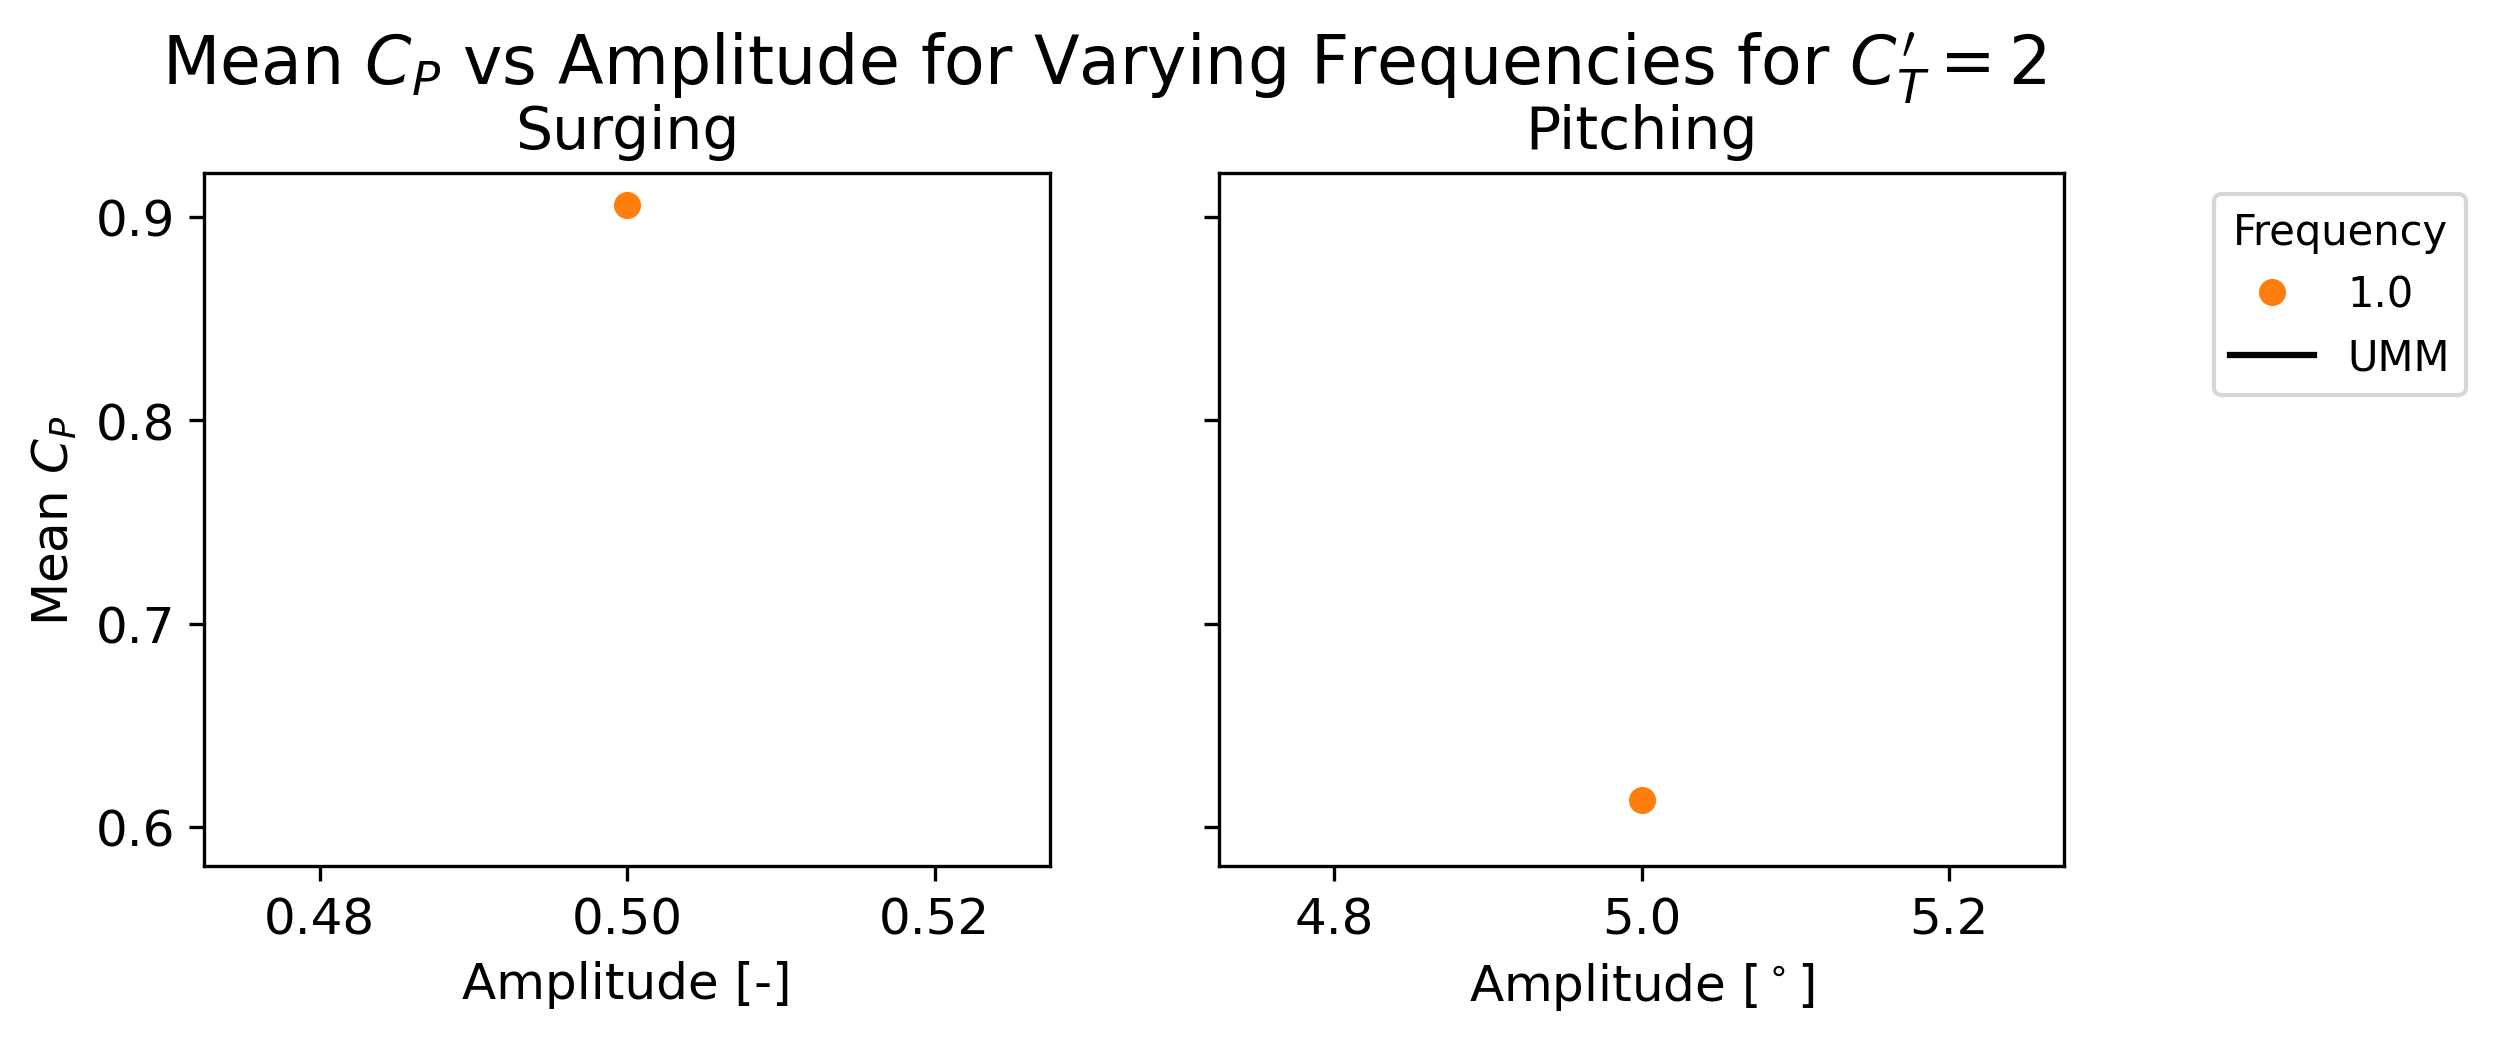

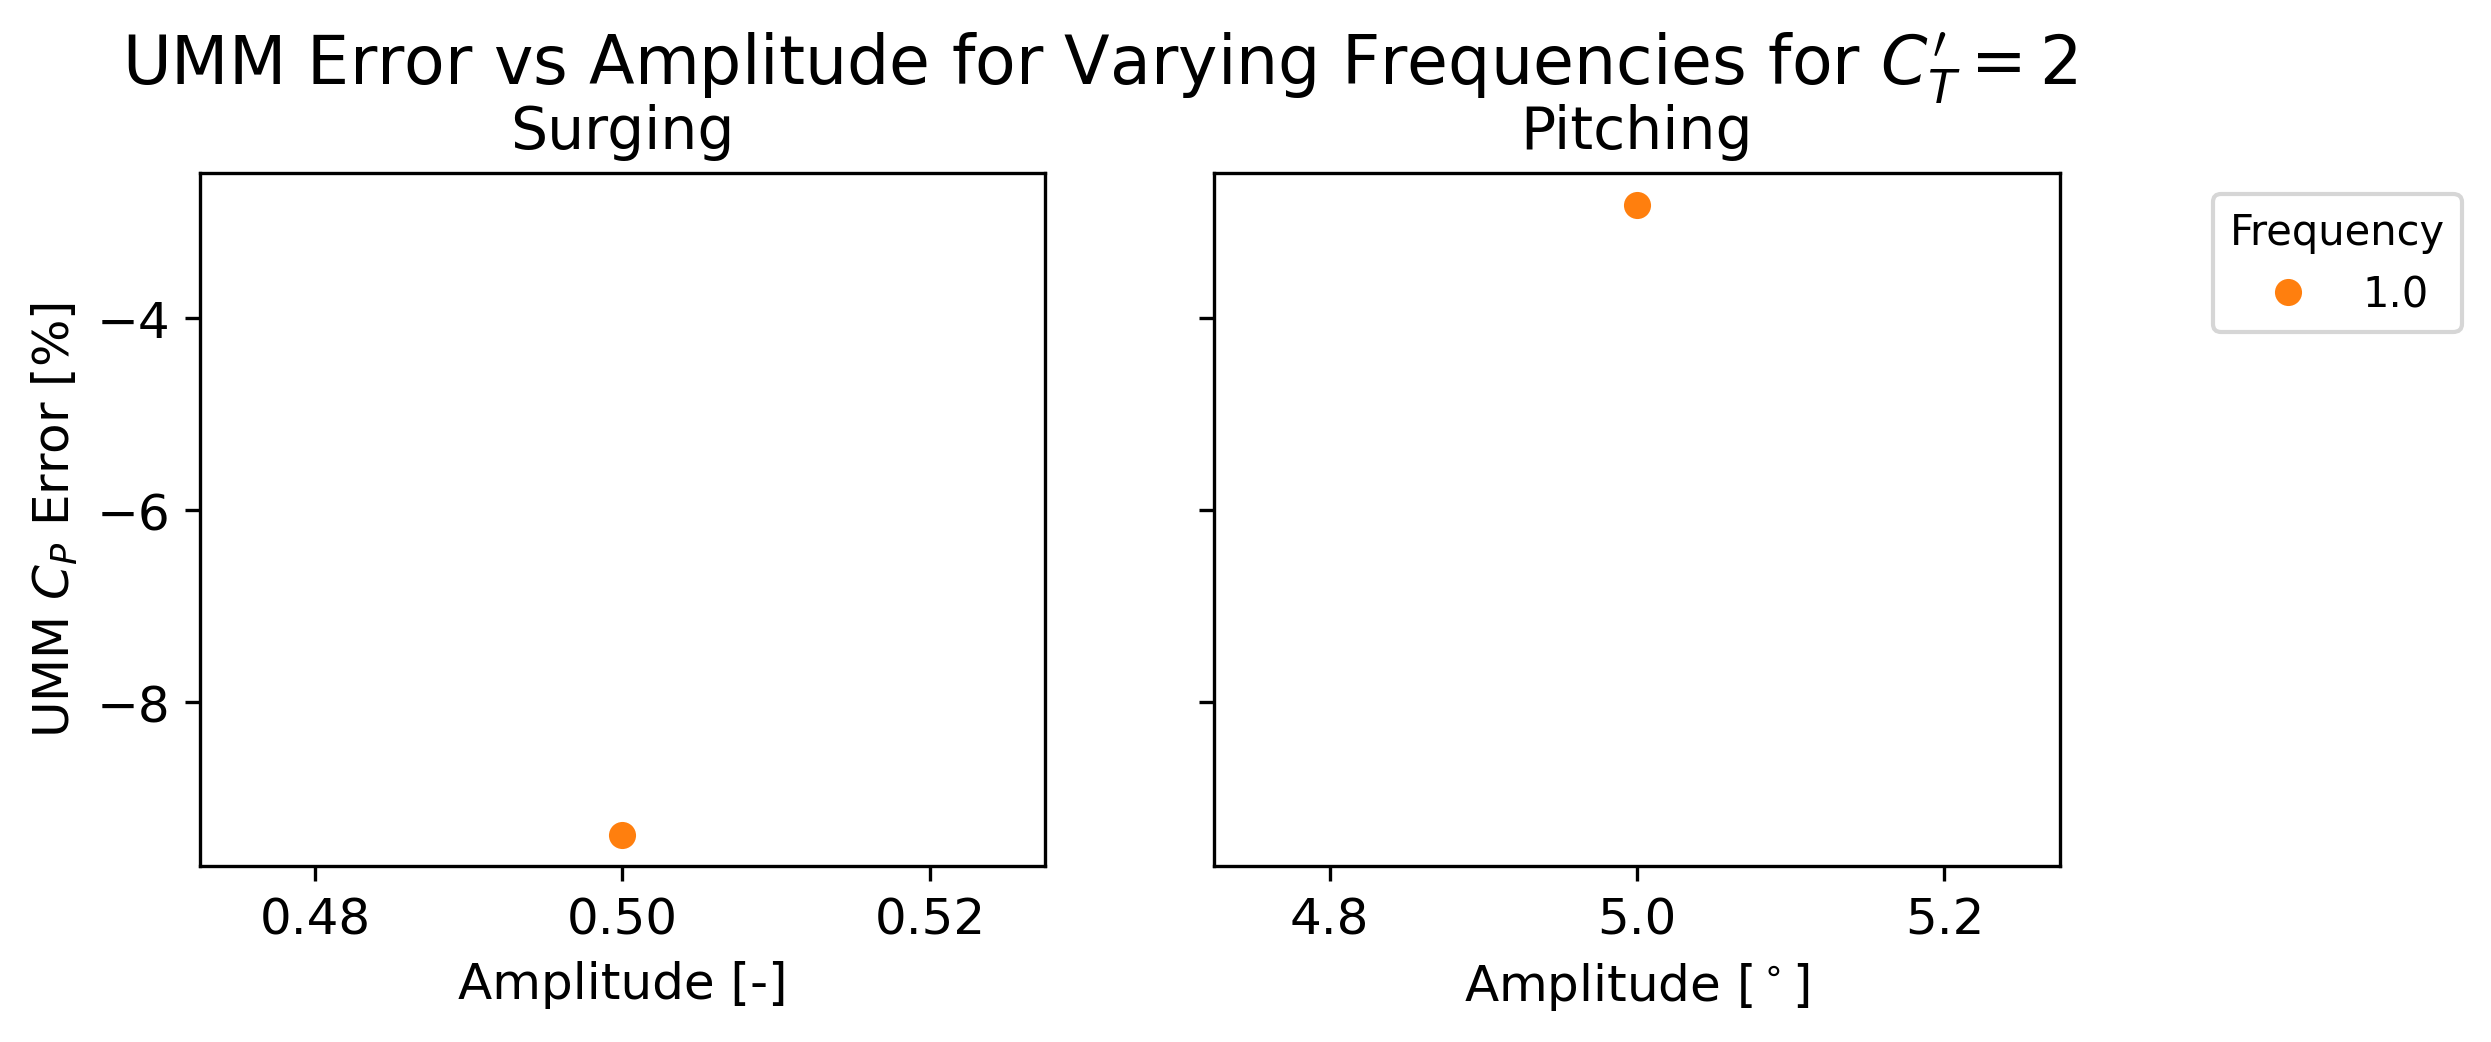

In [122]:
ctp = 2
mask = (df.filterFactor == 1.5) & (df.ny == 128) & (df.surge_freq < 1.5)
plot_umm_les(df, ctp, mask = mask)
plot_umm_error(df, ctp, mask = mask)

## Plot Mean $C_P$ from UMM for $C_T' = 4$ for a range of $f$ and $A$

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax0_data = ax0_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1_data = ax1_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:18: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_60521/1712811092.py:21: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq

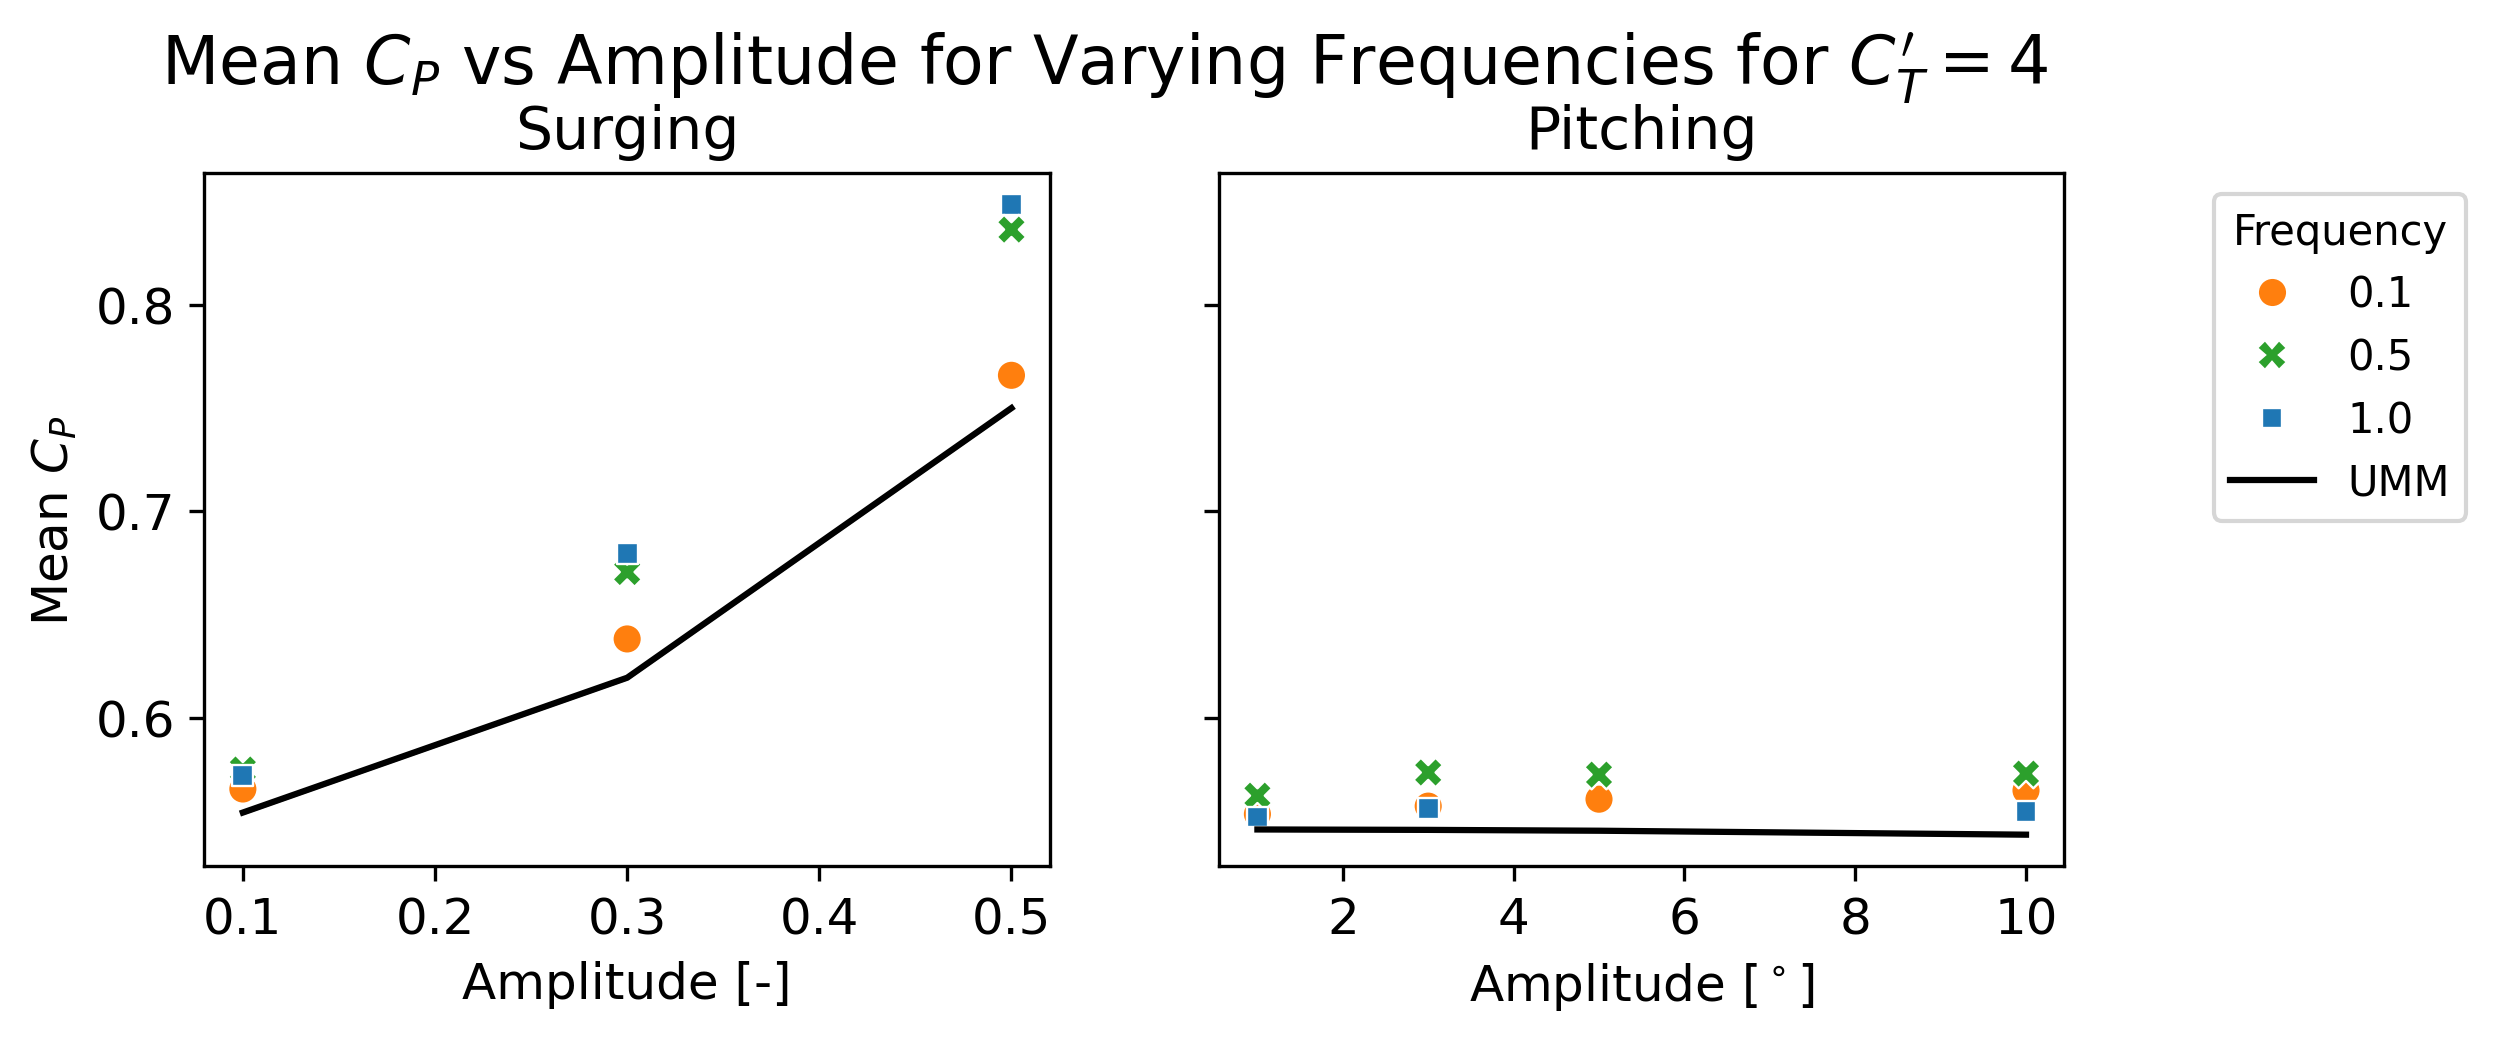

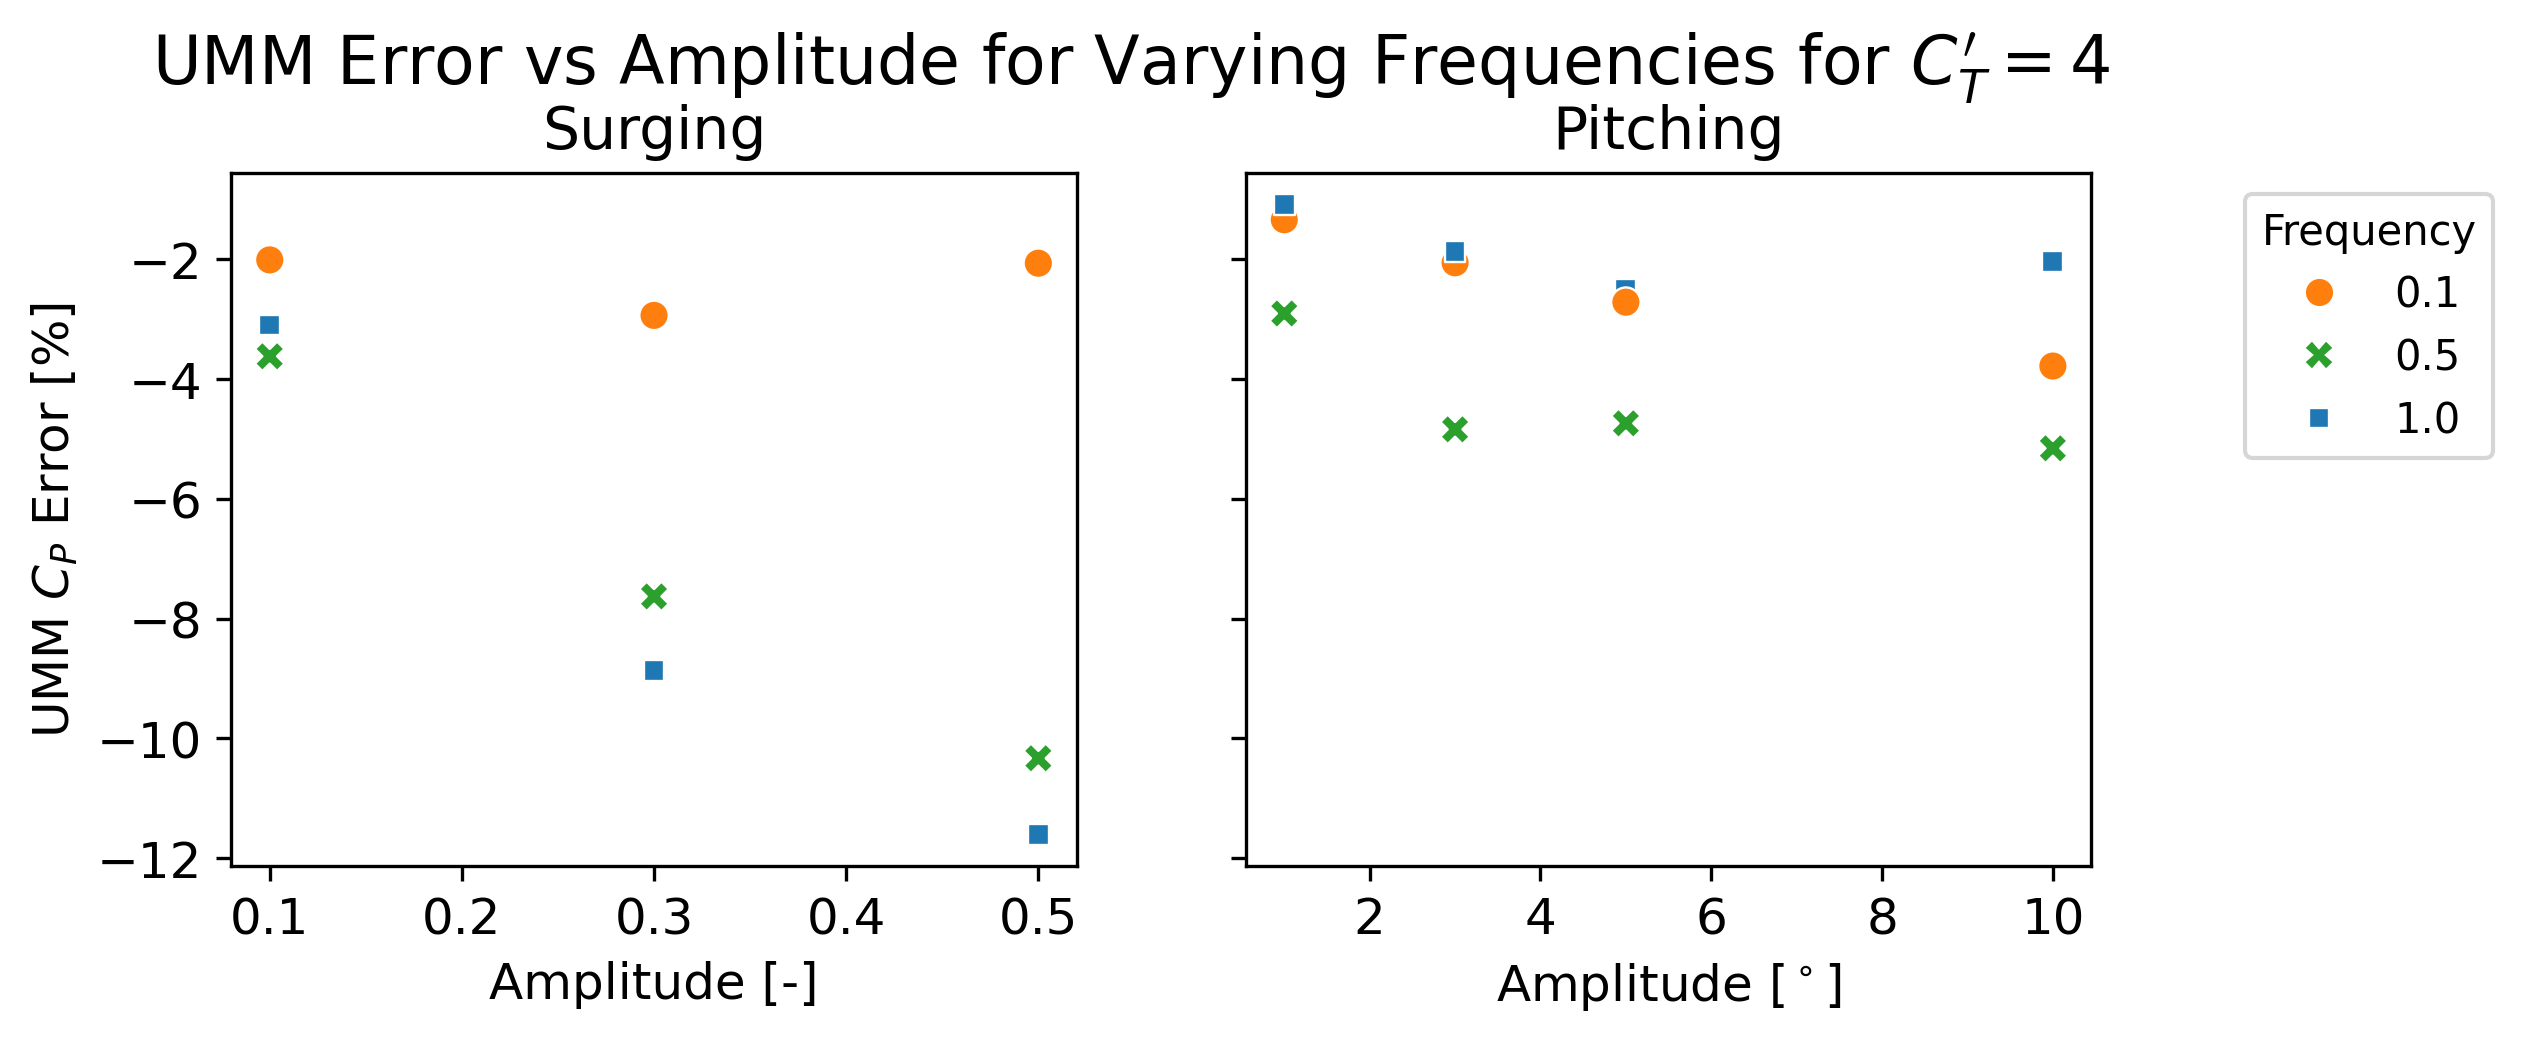

In [123]:
ctp = 4
mask = (df.filterFactor == 1.5) & (df.ny == 128) & (df.surge_freq < 1.5)
plot_umm_les(df, ctp, mask = mask)
plot_umm_error(df, ctp, mask = mask)

## High $C_T'$ Run Sensitivity

For high $C_T'$ values, small changes in LES parameters can lead to large changes in values. I decided to test this out for the above $C_T' = 4$ values as I wasn't sure I could trust them. This turned out to be the correct mindset, as the values differed a LOT based on the LES parameters. This, paired with my issues getting high resolution $C_T' = 4$ simulations to run, documented above, led me to give up on analyzing the $C_T' = 4$ case for now and focus on more realistic parameters.

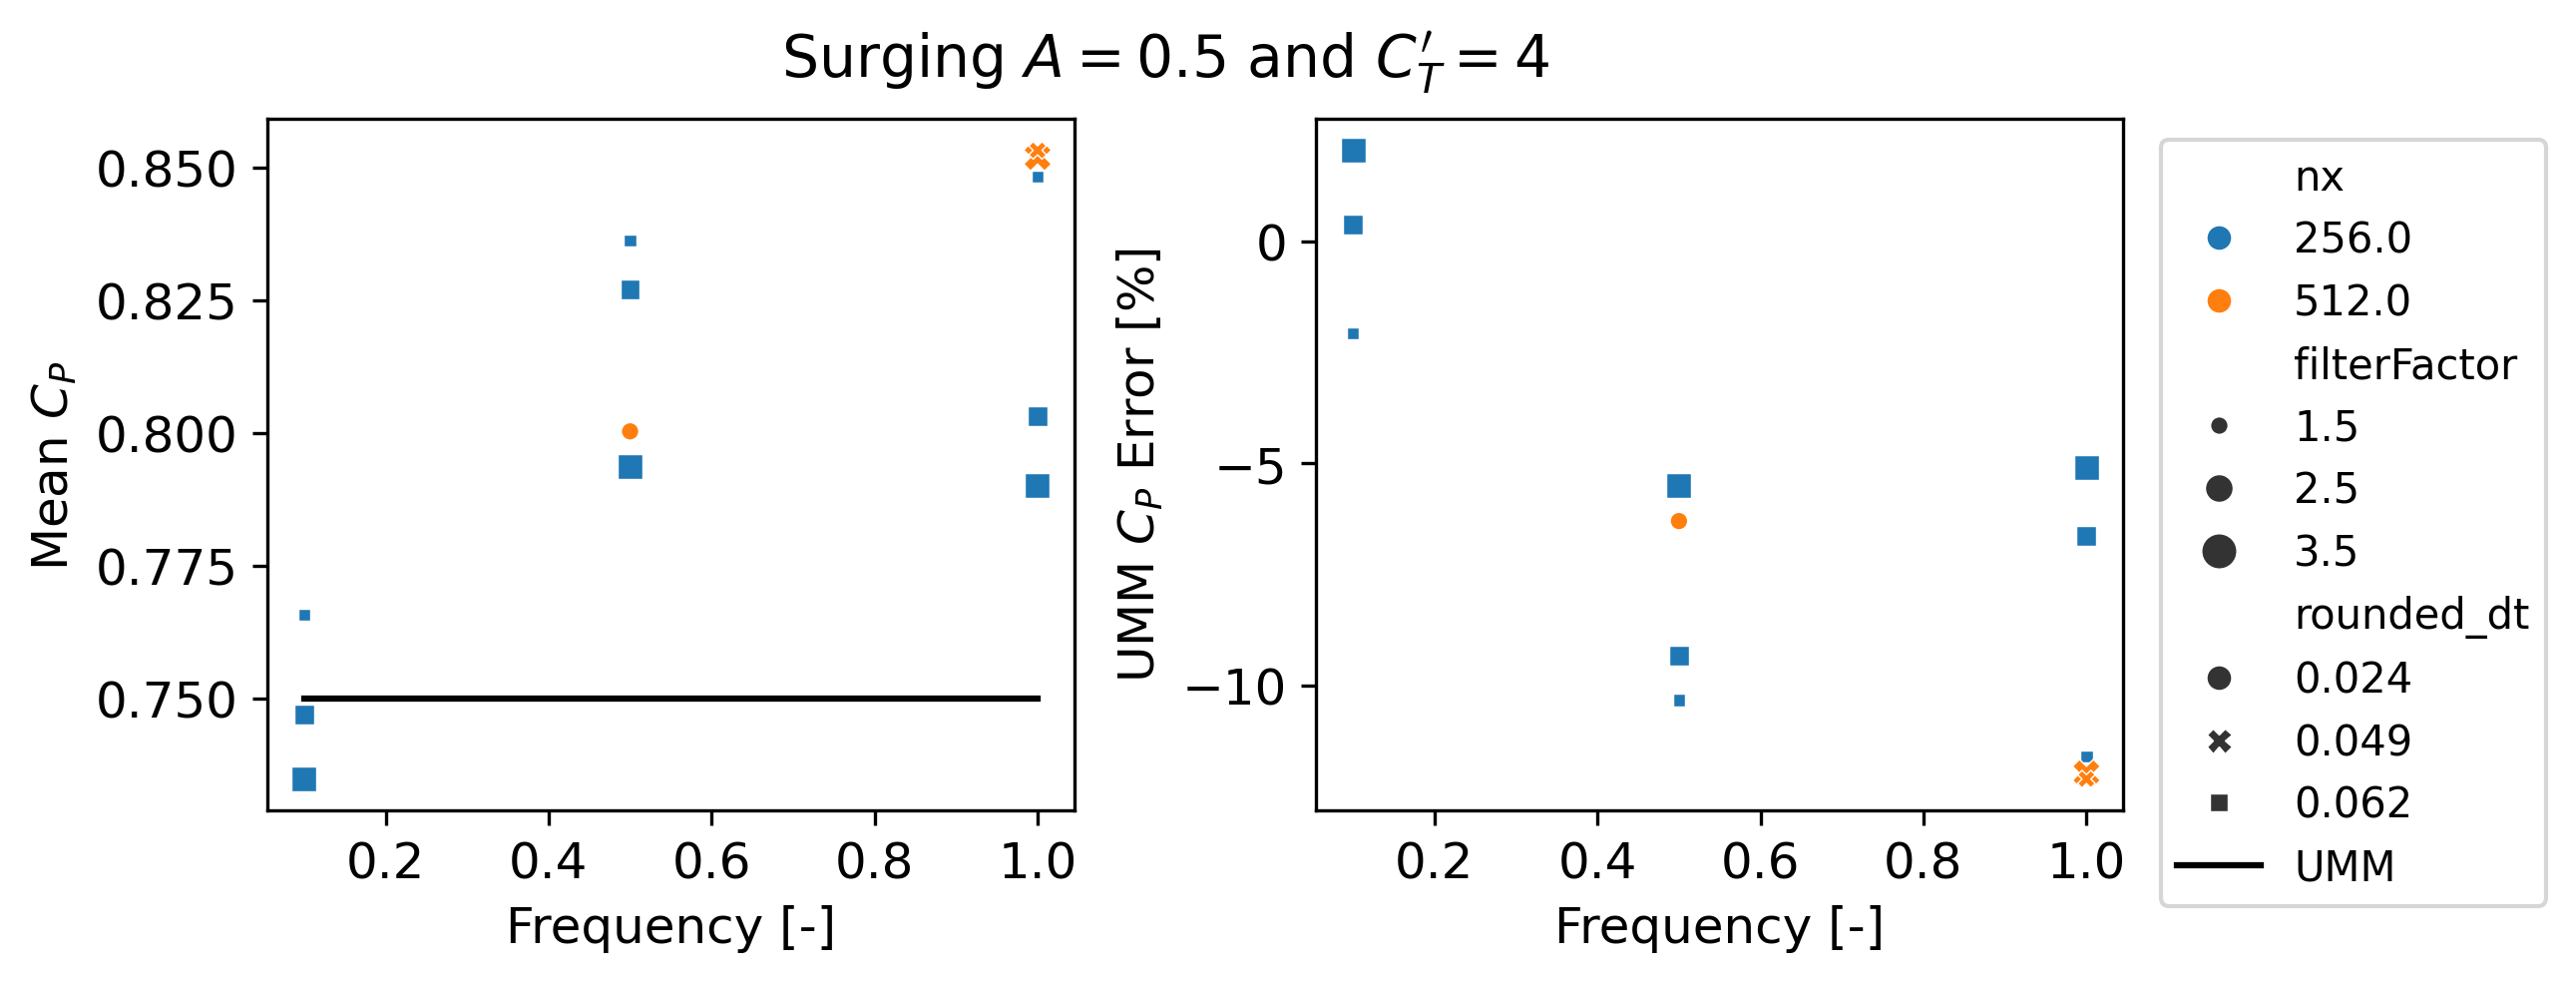

In [124]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (8, 3), dpi = 300)
fig.suptitle("Surging $A = 0.5$ and $C_T' = 4$", size = 14)
ax0.set_xlabel('Frequency [-]', size = 12)
ax0.set_ylabel('Mean $C_P$', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlabel('Frequency [-]', size = 12)
ax1.set_ylabel('UMM $C_P$ Error [%]', size = 12)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax0_data = df[(df.surge_amplitude == 0.5) & (df.CT_prime == 4)]

sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "mean_Cp", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor")
sns.lineplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "umm", color = "k", label = "UMM")

sns.scatterplot(ax = ax1, data = ax0_data, x = "surge_freq", y = "percent_diff_umm", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor", legend = False)
fix_plot_legend(ax0)
fig.subplots_adjust(wspace=0.3)


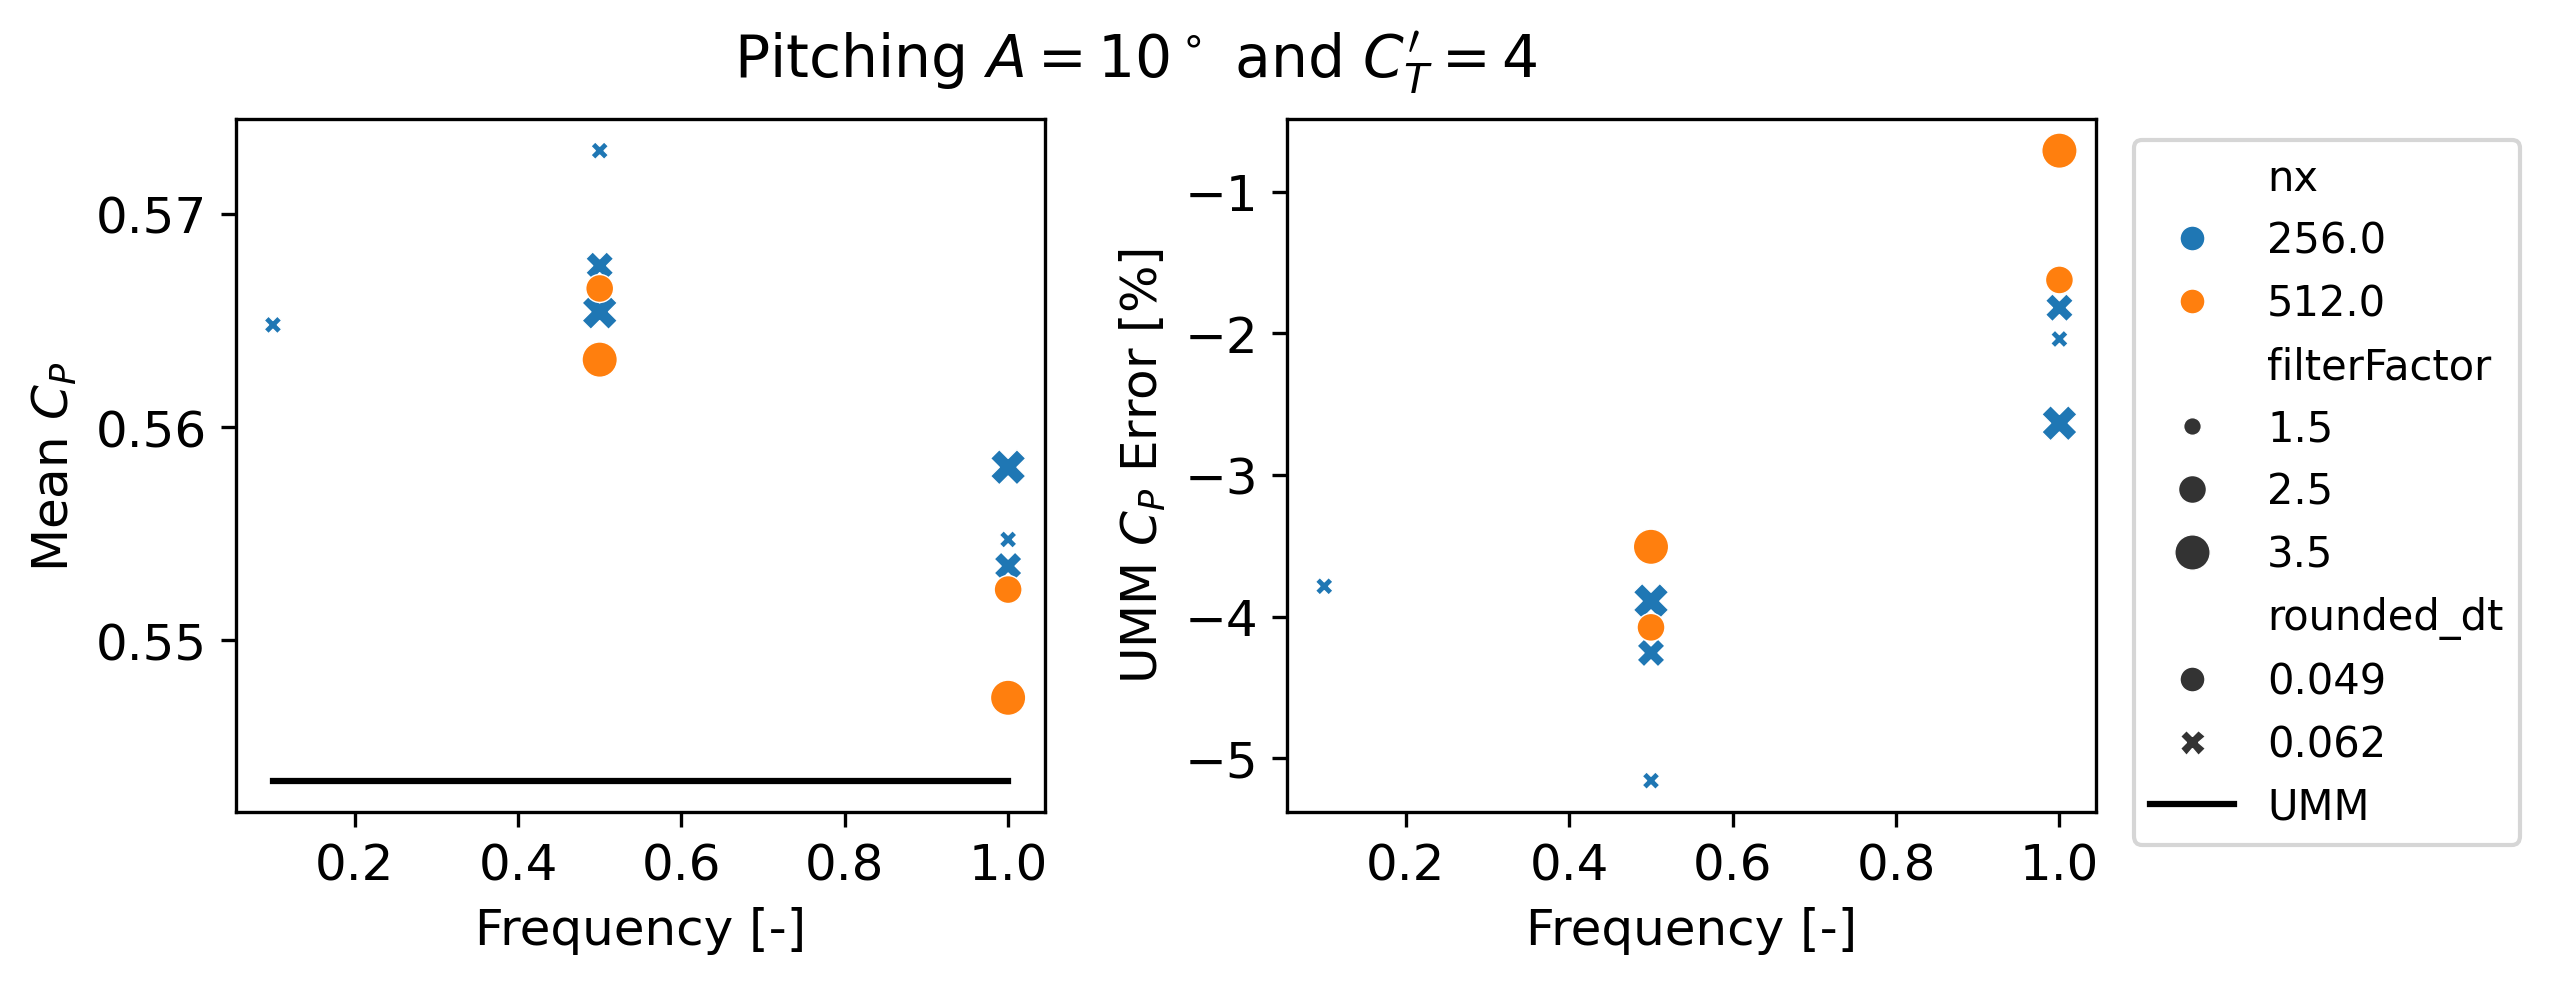

In [125]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (8, 3), dpi = 300)
fig.suptitle("Pitching $A = 10^\circ$ and $C_T' = 4$", size = 14)
ax0.set_xlabel('Frequency [-]', size = 12)
ax0.set_ylabel('Mean $C_P$', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlabel('Frequency [-]', size = 12)
ax1.set_ylabel('UMM $C_P$ Error [%]', size = 12)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax0_data = df[(df.pitch_amplitude == 10) & (df.CT_prime == 4)]

sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "mean_Cp", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor")
sns.lineplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "umm", color = "k", label = "UMM")

sns.scatterplot(ax = ax1, data = ax0_data, x = "surge_freq", y = "percent_diff_umm", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor", legend = False)
fix_plot_legend(ax0)
fig.subplots_adjust(wspace=0.3)